In [1]:
import sys
sys.path.insert(0, '..')
from dhmc.dhmc_sampler import DHMCSampler
from other_samplers.mcmc_diagnostic import mono_seq_ess

In [2]:
import numpy as np
import scipy.stats as stats
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Sample the posterior distribution of ``unknown $N$ and $p$'' example.
$y \, | \, p, N \sim \mathrm{Binomial}(p, N), \ \pi(N) \propto N^{-1}, \ p \sim \textrm{Beta}(\alpha, \beta)$

### Define the functions required by DHMCSampler.

In [3]:
alpha = 2
beta = 2
y = 100 # The observed number of successes.

In [4]:
def unpack_param(theta):
    logit_p = np.take(theta, 0, axis=-1)
    log_N = np.take(theta, 1, axis=-1)
    return logit_p, log_N

def f(theta, req_grad=True):
    
    logit_p, log_N = unpack_param(theta)
    
    # Check for the boundary & over-flow condition.
    N = math.floor(math.exp(log_N))
    if N < y or log_N > 30:
        return -float('inf'), np.full(theta.shape, float('nan')), None
    
    if abs(logit_p) > 30:
        return -float('inf'), np.full(theta.shape, float('nan')), None
    p = 1 / (1 + math.exp(-logit_p))
    
    grad = np.zeros(len(theta))
    jacobian = math.log((1 + N) / N)
    if np.any(jacobian == 0):
        logp = - float('inf')
        grad = np.full(len(theta), float('nan'))
    else:
        # Contributions from log transformation of N.
        logp = - math.log(jacobian)
        
        # Contributions from prior \pi(N) = N ** - 1, p \sim Beta(alpha, beta)
        logp += - math.log(N)
        logp += alpha * math.log(p) + beta * math.log(1 - p)
        grad[0] += (1 - p) * alpha - p * beta

        # Contributions from likelihood
        logp += y * math.log(p) + (N - y) * math.log(1 - p) + np.sum(np.log(np.arange(N - y + 1, N + 1)))
        grad[0] += (1 - p) * y - p * (N - y)
        

    return logp, grad, None

def f_update(theta, dtheta, j, aux):
    theta_ahead = theta.copy()
    theta_ahead[j] += dtheta
    logp_diff = f(theta_ahead)[0] - f(theta)[0]
    return logp_diff, None

In [5]:
logit_p = 0
log_N = math.log(2 * y)

n_param = 2
n_disc = 1
theta0 = np.array([logit_p, log_N])
scale = np.ones(n_param)

dhmc = DHMCSampler(f, f_update, n_disc, n_param, scale)
dhmc.test_cont_grad(theta0, sd=.1, n_test=10);
dhmc.test_update(theta0, sd=.1, n_test=10);

Test passed! The computed gradient seems to be correct.
Test passed! The logp differences agree.


### Run DHMC sampler.

In [6]:
seed = 1
n_burnin = 10 ** 2
n_sample = 10 ** 6
n_update = 10
dt = np.array([.08, .1])
nstep = np.array([15, 20])

samples, logp_samples, accept_prob, pathlen_ave, time_elapsed = \
    dhmc.run_sampler(theta0, dt, nstep, n_burnin, n_sample, 
                     seed=seed, n_update=n_update)
samples = samples[n_burnin:, :]
print('The average acceptance probability was {:.3g}.'.format(np.mean(accept_prob)))
print(
    'Effective sample sizes for each coordinate are ' 
    + ', '.join(['{:.2e}'.format(ess) for ess in mono_seq_ess(samples, axis=0)])
    + '.'
)

100010 iterations have been completed.
200020 iterations have been completed.
300030 iterations have been completed.
400040 iterations have been completed.
500050 iterations have been completed.
600060 iterations have been completed.
700070 iterations have been completed.
800080 iterations have been completed.
900090 iterations have been completed.
1000100 iterations have been completed.
The average acceptance probability was 0.967.
Effective sample sizes for each coordinate are 2.39e+05, 2.15e+05.


In [7]:
logit_p_samples, log_N_samples = unpack_param(samples)
p_samples = 1 / (1 + np.exp( - logit_p_samples))
N_samples = np.exp(log_N_samples)

### Take a look at the traceplot.

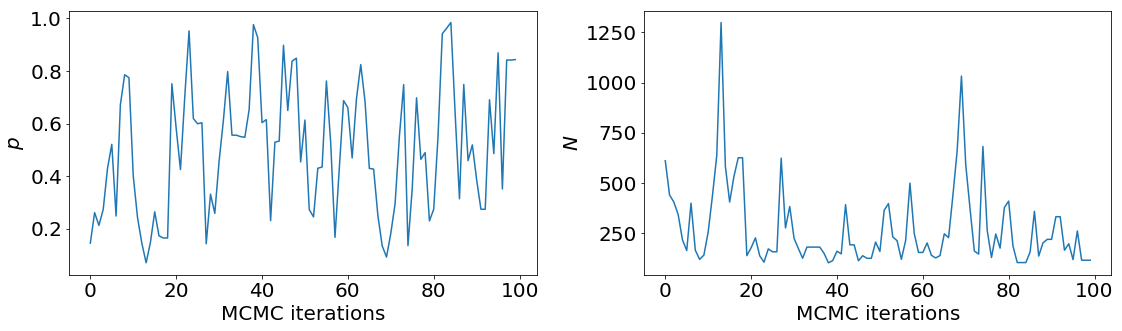

In [8]:
plt.figure(figsize=(16, 5))
plt.rcParams['font.size'] = 20

n_plot_pts = 100
plt.subplot(1, 2, 1)
plt.plot(p_samples[:n_plot_pts])
plt.ylabel(r'$p$')
plt.xlabel('MCMC iterations')

plt.subplot(1, 2, 2)
plt.plot(N_samples[:n_plot_pts])
plt.ylabel(r'$N$')
plt.xlabel('MCMC iterations')

plt.tight_layout()
plt.show()

# Compare the empirical distribution to the exact marginals.

### Compute the exact marginals.

In [9]:
def compute_N_logp(N):
    logp = \
        np.sum(np.log(np.arange(N - y + 1, N - y + beta))) - \
        np.sum(np.log(np.arange(N, N + alpha + beta)))
    return logp

def compute_p_density(p):
    
    N_vals = np.arange(y, 10 ** 4)
    N_density = np.exp([
        compute_N_logp(N) for N in N_vals
    ])
    N_density /= np.sum(N_density)

    p_conditional_density = np.hstack([
        beta_density(p_center, N)[:, np.newaxis]
        for N in N_vals
    ])
    p_density = np.dot(p_conditional_density, N_density)
    
    return p_density

def beta_density(p, N):
    # Returns (normalized) density of Beta(y + alpha, N - y + beta)
    logp = (N - y + beta - 1) * np.log(1 - p) + (y + alpha - 1) * np.log(p)
    logp += np.sum(np.log(np.arange(N - y + beta, N + alpha + beta))) - np.sum(np.log(np.arange(1, y + alpha)))
    return np.exp(logp)

In [10]:
bin_width = 5
N_bins = np.arange(y, 10 ** 3 + 1, bin_width) - bin_width / 2
N_center = np.arange(y, 10 ** 3, bin_width)
true_N_density = np.exp([
    compute_N_logp(N) for N in N_center
])
true_N_density /= np.sum(true_N_density) * bin_width

In [11]:
p_bins = np.linspace(0, 1, 101)
p_center = (p_bins[1:] + p_bins[:-1]) / 2

true_p_density = compute_p_density(p_center)

### Plot the normalized histograms of DHMC samples along with the exact densities.

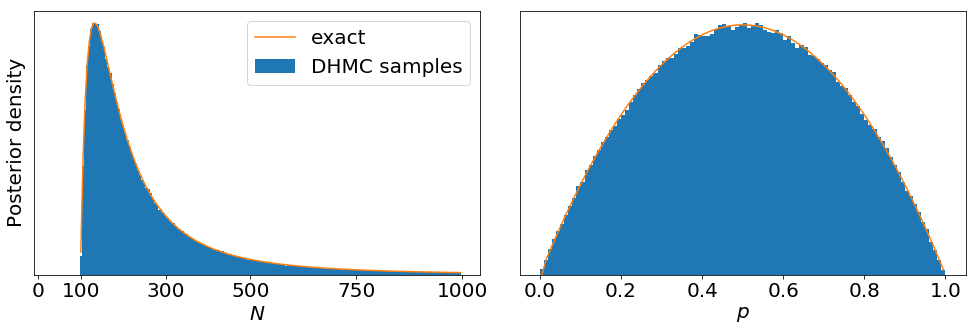

In [12]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 20

plt.subplot(1, 2, 1)
hist, _ = np.histogram(N_samples, bins=N_bins, normed='True')
width = N_bins[1] - N_bins[0]
plt.bar(N_center, hist, align='center', width=width, label='DHMC samples')
plt.plot(N_center, true_N_density, color='tab:orange', label='exact')
plt.xticks([0, 100, 300, 500, 750, 1000])
plt.xlim(xmin=-10)
plt.yticks([])
plt.xlabel(r'$N$')
plt.ylabel('Posterior density', labelpad=8)
plt.legend()

plt.subplot(1, 2, 2)
hist, _ = np.histogram(p_samples, bins=p_bins, normed='True')
width = p_bins[1] - p_bins[0]
plt.bar(p_center, hist, align='center', width=width)
plt.plot(p_center, true_p_density, color='tab:orange')
plt.yticks([])
plt.xlabel(r'$p$')

plt.tight_layout()
plt.show()

### Plot the joint posterior (empirical distribution), so you know how the DHMC target looks like.

In [13]:
n_bins = 51
logit_p_bins = np.linspace(-4, 4, n_bins)
log10_N_bins = np.linspace(2, 4, n_bins)

log10_N_samples = np.log10(N_samples)
within_bdry = (
    (logit_p_samples < np.max(logit_p_bins)) 
    & (logit_p_samples > np.min(logit_p_bins))
    & (log10_N_samples < np.max(log10_N_bins))
)

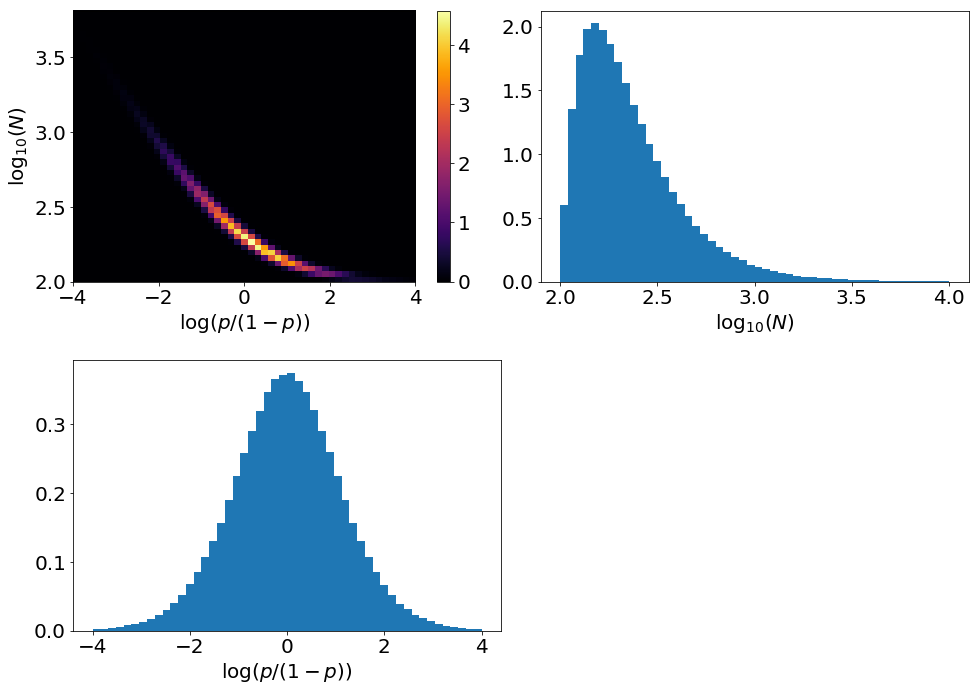

In [14]:
plt.figure(figsize=(14, 10))
plt.rcParams['font.size'] = 20

plt.subplot(2, 2, 1)
n_threshold = 10 ** 5
plt.hist2d(logit_p_samples[within_bdry], 
           log10_N_samples[within_bdry], 
           bins=n_bins, normed=1, cmap='inferno')
plt.ylabel(r'$\log_{10}(N)$')
plt.xlabel(r'$\log(p / (1 - p))$')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.hist(log10_N_samples, bins=log10_N_bins, normed=1)
plt.xlabel(r'$\log_{10}(N)$')

plt.subplot(2, 2, 3)
plt.hist(logit_p_samples, bins=logit_p_bins, normed=1)
plt.xlabel(r'$\log(p / (1 - p))$')

plt.tight_layout()
plt.show()

# Repeat the same simulation except with larger stepsize for the integrator.

In [15]:
dt *= 1.7
nstep = np.ceil(nstep / 1.7)

In [16]:
samples, logp_samples, accept_prob, pathlen_ave, time_elapsed = \
    dhmc.run_sampler(theta0, dt, nstep, n_burnin, n_sample, 
                     seed=seed, n_update=n_update)
samples = samples[n_burnin:, :]
print('The average acceptance probability was {:.3g}.'.format(np.mean(accept_prob)))
print(
    'Effective sample sizes for each coordinate are ' 
    + ', '.join(['{:.2e}'.format(ess) for ess in mono_seq_ess(samples, axis=0)])
    + '.'
)

100010 iterations have been completed.
200020 iterations have been completed.
300030 iterations have been completed.
400040 iterations have been completed.
500050 iterations have been completed.
600060 iterations have been completed.
700070 iterations have been completed.
800080 iterations have been completed.
900090 iterations have been completed.
1000100 iterations have been completed.
The average acceptance probability was 0.895.
Effective sample sizes for each coordinate are 9.39e+04, 1.02e+05.


In [17]:
logit_p_samples, log_N_samples = unpack_param(samples)
p_samples = 1 / (1 + np.exp( - logit_p_samples))
N_samples = np.exp(log_N_samples)

### The sampler is now "stickier" and less efficiently explores the space.

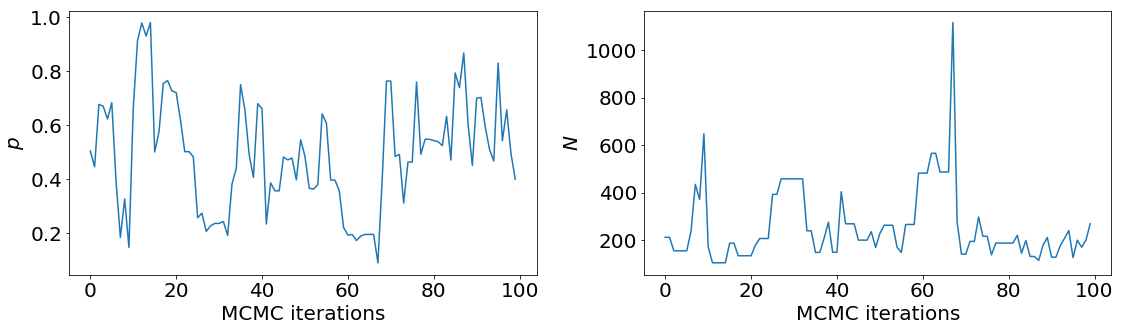

In [18]:
plt.figure(figsize=(16, 5))
plt.rcParams['font.size'] = 20

n_plot_pts = 100
plt.subplot(1, 2, 1)
plt.plot(p_samples[:n_plot_pts])
plt.ylabel(r'$p$')
plt.xlabel('MCMC iterations')

plt.subplot(1, 2, 2)
plt.plot(N_samples[:n_plot_pts])
plt.ylabel(r'$N$')
plt.xlabel('MCMC iterations')

plt.tight_layout()
plt.show()

### The empirical distribution is still asymptotically exact.

In [19]:
bin_width = 5
N_bins = np.arange(y, 10 ** 3 + 1, bin_width) - bin_width / 2
N_center = np.arange(y, 10 ** 3, bin_width)
true_N_density = np.exp([
    compute_N_logp(N) for N in N_center
])
true_N_density /= np.sum(true_N_density) * bin_width

In [20]:
p_bins = np.linspace(0, 1, 101)
p_center = (p_bins[1:] + p_bins[:-1]) / 2

true_p_density = compute_p_density(p_center)

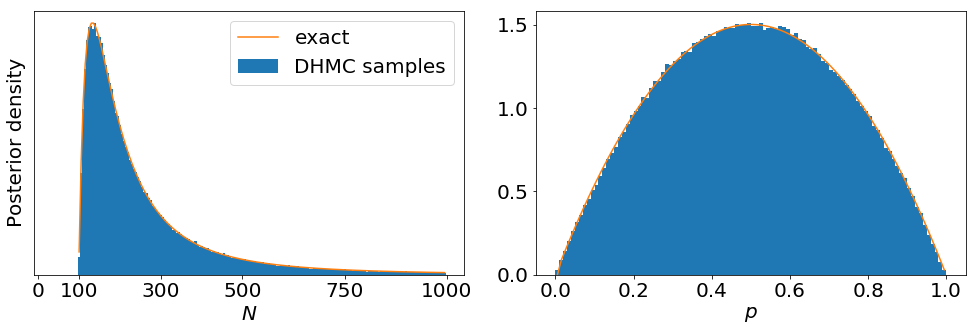

In [21]:
plt.figure(figsize=(14, 5))
plt.rcParams['font.size'] = 20

plt.subplot(1, 2, 1)
hist, _ = np.histogram(N_samples, bins=N_bins, normed='True')
width = N_bins[1] - N_bins[0]
plt.bar(N_center, hist, align='center', width=width, label='DHMC samples')
plt.plot(N_center, true_N_density, color='tab:orange', label='exact')
plt.xticks([0, 100, 300, 500, 750, 1000])
plt.xlim(xmin=-10)
plt.yticks([])
plt.xlabel(r'$N$')
plt.ylabel('Posterior density', labelpad=8)
plt.legend()

plt.subplot(1, 2, 2)
hist, _ = np.histogram(p_samples, bins=p_bins, normed='True')
width = p_bins[1] - p_bins[0]
plt.bar(p_center, hist, align='center', width=width)
plt.plot(p_center, true_p_density, color='tab:orange')
plt.yticks()
plt.xlabel(r'$p$')

plt.tight_layout()
plt.show()